## Método de colocación con PyTorch


A continuación se implementará el método de colocación utilizando un optimizador y la función de autodiferenciación de PyTorch. 

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

## Función de aproximación propuesta

Utilizando una aproximación a la solución de la siguiente forma

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [2]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$

Considerando el caso de N=3, tenemos que:

$$
-c_0 x^2 + c_0 x - 2c_0 - c_1 x^3 + c_1 x^2 - 6c_1 x + 2c_1 - c_2 x^4 + c_2 x^3 - 12c_2 x^2 + 6c_2 x - c_3 x^5 + c_3 x^4 - 20c_3 x^3 + 12c_3 x^2 + x
$$

In [3]:
def residuo(x, c):
    terms = [
        -c[0]*x**2 + c[0]*x - 2*c[0],
        -c[1]*x**3 + c[1]*x**2 - 6*c[1]*x + 2*c[1],
        -c[2]*x**4 + c[2]*x**3 - 12*c[2]*x**2 + 6*c[2]*x,
        -c[3]*x**5 + c[3]*x**4 - 20*c[3]*x**3 + 12*c[3]*x**2
    ]
    return sum(terms) + x

### Optimización de coeficientes

Optimización de cuatro coeficientes para cuatro valores de $x$.

In [4]:
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True) 

def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

c = initialize_coefficients(4).requires_grad_(True)

# Función de pérdida
def loss_fn(x, c):
    y = residuo(x, c)
    loss = torch.mean(y ** 2)  # Mean squared error
    return loss

optimizer = torch.optim.Adam([c], lr=0.1)

for epoch in range(1_000):  # Number of iterations
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(x, c)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    if epoch % 100 == 0:  # Print progress every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, c: {c.data}')

print(f'Optimized c: {c.data}')

Epoch 0, Loss: 0.8254674077033997, c: tensor([ 0.1616,  0.5992, -0.0064, -0.2307])
Epoch 100, Loss: 2.1054240278317593e-05, c: tensor([ 0.1839,  0.2172, -0.0698,  0.0307])
Epoch 200, Loss: 1.219519617734477e-05, c: tensor([ 0.1844,  0.2134, -0.0602,  0.0238])
Epoch 300, Loss: 7.681270290049724e-06, c: tensor([ 0.1852,  0.2083, -0.0500,  0.0171])
Epoch 400, Loss: 4.367718247522134e-06, c: tensor([ 0.1860,  0.2035, -0.0403,  0.0107])
Epoch 500, Loss: 2.2561364403372863e-06, c: tensor([ 0.1867,  0.1993, -0.0319,  0.0053])
Epoch 600, Loss: 1.0615641485856031e-06, c: tensor([ 0.1872,  0.1960, -0.0252,  0.0009])
Epoch 700, Loss: 4.5542373072748887e-07, c: tensor([ 0.1876,  0.1935, -0.0201, -0.0024])
Epoch 800, Loss: 1.7806758023652947e-07, c: tensor([ 0.1879,  0.1917, -0.0166, -0.0047])
Epoch 900, Loss: 6.336657065730833e-08, c: tensor([ 0.1881,  0.1905, -0.0141, -0.0063])
Optimized c: tensor([ 0.1882,  0.1897, -0.0126, -0.0073])


Gráfica de la predición obtenido.

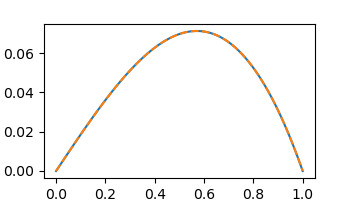

In [5]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
y_true.detach().numpy()
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica del residuo obtenido luego de la optimización.

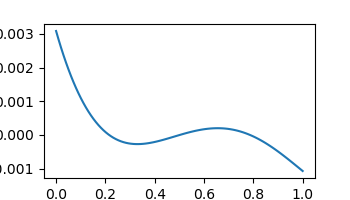

In [6]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo.

In [7]:
#  Error relativo
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

8.6866254e-05

## Utilizando diferenciación automática


En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [8]:
# Derivada
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

# Residuo
def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

# Función de pérdida
def loss_fn(x, c):
    y = residuo(x, c)
    return torch.mean(y ** 2)  # Error cuadrático medio

# Configuración de datos y parámetros
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True)

# Inicialización de coeficientes utilizando Xavier
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

# Configuración del optimizador
c = initialize_coefficients(4).requires_grad_(True)

In [9]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 1_000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x, c)  # Calcular la pérdida
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item()}, c: {c.data}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 0.988703191280365, c: tensor([-0.2107,  0.1417,  0.0189,  0.3177])
Epoch 100, Loss: 5.80908490519505e-05, c: tensor([ 0.1824,  0.2372, -0.1096,  0.0538])
Epoch 200, Loss: 2.7259698981652036e-05, c: tensor([ 0.1825,  0.2256, -0.0847,  0.0398])
Epoch 300, Loss: 1.3008006135351025e-05, c: tensor([ 0.1843,  0.2141, -0.0618,  0.0248])
Epoch 400, Loss: 5.2542386583809275e-06, c: tensor([ 0.1858,  0.2049, -0.0431,  0.0126])
Epoch 500, Loss: 1.8129526324628387e-06, c: tensor([ 0.1868,  0.1982, -0.0297,  0.0038])
Epoch 600, Loss: 5.362093702387938e-07, c: tensor([ 0.1875,  0.1939, -0.0209, -0.0019])
Epoch 700, Loss: 1.3599813541986805e-07, c: tensor([ 0.1879,  0.1913, -0.0158, -0.0052])
Epoch 800, Loss: 2.9529051204235657e-08, c: tensor([ 0.1882,  0.1899, -0.0130, -0.0071])
Epoch 900, Loss: 5.472850617138647e-09, c: tensor([ 0.1883,  0.1892, -0.0116, -0.0080])
Optimized c: tensor([ 0.1883,  0.1889, -0.0110, -0.0084])


Gráfica de la predicción obtenida.

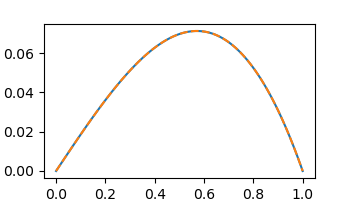

In [10]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica el residuo obtenido luego de la optimización.

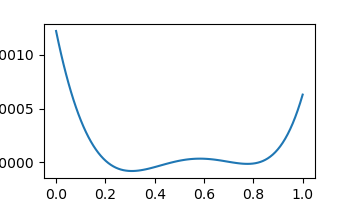

In [11]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo para la apróximación con diferenciación automática.

In [12]:
#  Error relativo
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

5.5248805e-05